To start this exercise, pick a dataset. It could be one you've worked with before or it could be a new dataset. Then build the best decision tree that you can.


Now, try to match that with the simplest random forest that you can. For this exercise, measure simplicity with runtime. Compare that to the runtime of the decision tree. This is imperfect, but just go with it.


Hopefully, out of this you'll see the power of random forests, but you'll also see their potential costs. Remember, in the real world, you won't necessarily be dealing with thousands of rows. There may be millions, billions, or even more.



In [62]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dask import dataframe as dd 
from dask.distributed import Client, progress
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import OneHotEncoder
import dask.array as da
import joblib


from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from category_encoders import LeaveOneOutEncoder


**Getting the data and cleaning**

In [7]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [37]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')
sd = dd.from_pandas(df, npartitions=3)


In [38]:
#deal with missing values
drop_cols=[]
for col in sd.columns:
    if df[col].isna().mean()>.4:
        drop_cols=drop_cols+[col]
df_clean=sd.drop(columns=drop_cols).dropna()


In [39]:
#for dask, you need to use mask instead of loc 
df_clean['secondflrexists']=0
df_clean['secondflrexists']=df_clean['secondflrexists'].mask(df_clean['secondflrsf']>0,1) #can prob drop 2nd fl sq ft
df_clean['yrsbltqared']=df_clean['yearbuilt']*df_clean['yearbuilt']
df_clean['agebuilt']=df_clean['yrsold']-df_clean['yearbuilt']
df_clean['ageremodeled']=df_clean['yrsold']-df_clean['yearremodadd']
df_clean['agebuiltsquared']=df_clean['agebuilt']*df_clean['agebuilt']
df_clean['agebuiltcubed']=df_clean['agebuilt']*df_clean['agebuilt']*df_clean['agebuilt']


In [40]:
df_clean['overallqualsquared']=df_clean['overallqual']*df_clean['overallqual']
df_clean['overallqualcubed']=df_clean['overallqual']*df_clean['overallqual']*df_clean['overallqual']
df_clean['grlivareasquared']=df_clean['grlivarea']*df_clean['grlivarea']
df_clean['ageremodeledsquared']=df_clean['ageremodeled']*df_clean['ageremodeled']
df_clean['totalsf']=df_clean['totalbsmtsf']+df_clean['grlivarea']
df_clean['lotareasquared']=df_clean['lotarea']*df_clean['lotarea']

#making partial,centralair and the neighborhood a binary variable
niceneighborhoods=['NridgHt', 'NoRidge', 'Somerst', 'Timber', 'Veenker', 'StoneBr']
goodneighborhoods=['ClearCr','Crawfor','CollgCr','Gilbert','Blmngtn','SawyerW','NWAmes']

df_clean['nicehood']=0
df_clean['nicehood']=df_clean['nicehood'].mask(df_clean.neighborhood.isin(niceneighborhoods),1)
# df_clean['hoodrank']=0
# df_clean.loc[df_clean.neighborhood.isin(goodneighborhoods),'hoodrank']=1
# df_clean.loc[df_clean.neighborhood.isin(niceneighborhoods),'hoodrank']=2
df_clean['goodhood']=0
df_clean['goodhood']=df_clean['goodhood'].mask(df_clean.neighborhood.isin(goodneighborhoods),1)

#Making binary cats ints
# df_clean['sale_partial']=0
# df_clean.loc[df_clean.salecondition=='Partial','sale_partial']=1
df_clean['centralairint']=0
df_clean['centralairint']=df_clean['centralairint'].mask(df_clean.centralair=='Y',1)
# df_clean['remodeled']=1
# df_clean.loc[df_clean.agebuilt==df_clean.ageremodeled,'remodeled']=0
# df_clean['pavedDW']=0
# df_clean.loc[df_clean.paveddrive=='P','pavedDW']=1
df_clean['haspool']=0
df_clean['haspool']=df_clean['haspool'].mask(df_clean.poolarea>0,1)

#Making some interaction variables:
df_clean['nicehood_quality']=df_clean['overallqual']*df_clean['nicehood']
# df_clean['goodhood_quality']=df_clean['overallqual']*df_clean['goodhood']
df_clean['nicehood_totalsf']=df_clean['totalsf']*df_clean['nicehood']
df_clean['goodhood_totalsf']=df_clean['totalsf']*df_clean['goodhood']

df_clean['totaloutside']=(df_clean['enclosedporch']+df_clean['wooddecksf']+ 
                          df_clean['openporchsf']+df_clean['threessnporch']+
                          df_clean['screenporch']#+df_clean['poolarea']
                         )
df_clean['totaloutside_quality']=df_clean['overallqual']*df_clean['totaloutside']


In [63]:
cat_cols=['nicehood','goodhood','centralairint','salepartial']
num_cols=['overallqual',
          'overallqualsquared',
          'overallqualcubed',
          'grlivarea',
          'totalbsmtsf',
          'garagearea',
          'lotarea',
          'lotareasquared',
          'ageremodeled',
          'ageremodeledsquared',
          'agebuilt',
          'agebuiltsquared',
          'bedroomabvgr']

X = df_clean[['overallqual',
              'overallqualsquared',#
              'overallqualcubed',#
              'grlivarea',
              'grlivareasquared',#
               'totalbsmtsf',
               'garagearea', 
               'lotarea',
              'lotareasquared',
               'ageremodeled',
               'ageremodeledsquared',
               'agebuilt',
               'agebuiltsquared',
              'centralairint',
              'bedroomabvgr',#
              'nicehood_totalsf',
              'goodhood_totalsf',
              'totaloutside',
              'secondflrexists',#
              'haspool',
              ]]
y = df_clean['saleprice']
y_log=da.log(y)


In [64]:
#I had to use compute here because I didn't have dask_ml
X_train, X_test, y_log_train, y_log_test=train_test_split(X,y_log,test_size=.2,random_state=1)
# X_train = dd.from_pandas(X_train, npartitions=3)
# X_test = dd.from_pandas(X_test, npartitions=3)
# y_log_test = dd.from_pandas(y_log_test, npartitions=3)
# y_log_train = dd.from_pandas(y_log_train, npartitions=3)


/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/dask_ml/model_selection/_split.py:469: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  category=FutureWarning,


**y vs y log:**

[]

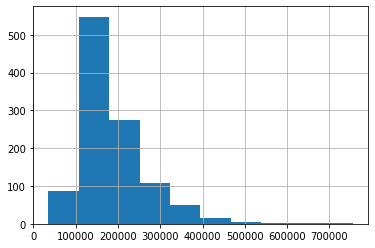

In [65]:
y.compute().hist().plot()

[]

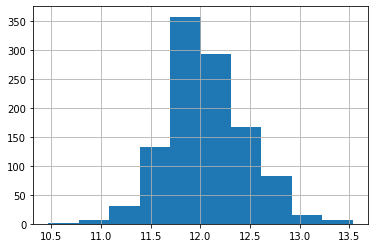

In [66]:
y_log.compute().hist().plot()

**Random Forests**

In [47]:
import time
start_time = time.time()


grid = {"max_depth": [5,6,8], "n_estimators": [50],'min_samples_leaf':[5, 10]}
model = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=4,
    #     scoring=make_scorer(f1_score),
#     scoring=make_scorer(roc_auc_score),
    verbose=1,
)

with joblib.parallel_backend('dask'):
    model.fit(X_train.compute(), y_log_train.compute())
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   12.5s finished
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  state = self.__dict__.copy()


--- 13.565860748291016 seconds ---


In [48]:
print(model.score(X_train.compute(), y_log_train.compute()))
print(model.score(X_test.compute(), y_log_test.compute()))


0.9240848403475677
0.8644790349174818


In [50]:
#timing without cross validation:

start_time = time.time()

model= RandomForestRegressor(min_samples_leaf=20, max_depth=8, n_estimators=50)
with joblib.parallel_backend('dask'):
    model.fit(X_train.compute(), y_log_train.compute())
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.6189010143280029 seconds ---


**Decision Trees**

In [52]:
start_time = time.time()


model = DecisionTreeRegressor(min_samples_leaf=15, max_depth=10)
with joblib.parallel_backend('dask'):
    model.fit(X_train.compute(), y_log_train.compute())

    y_log_preds=model.predict(X_test.compute())
    y_log_train_preds=model.predict(X_train.compute())

print(model.score(X_train.compute(), y_log_train.compute()))
print(model.score(X_test.compute(), y_log_test.compute()))
print("--- %s seconds ---" % (time.time() - start_time))


0.8667094681694627
0.7983979678286635
--- 1.4344358444213867 seconds ---


In [70]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
